# 1. 트랜스포머 모델의 개괄

### 1.1. 트랜스포머란?


왼쪽이 인코더(Encoder) 레이어, 오른쪽이 디코더(Decoder) 레이어

셀프 어텐션과 멀티 헤드 어텐션을 수행함

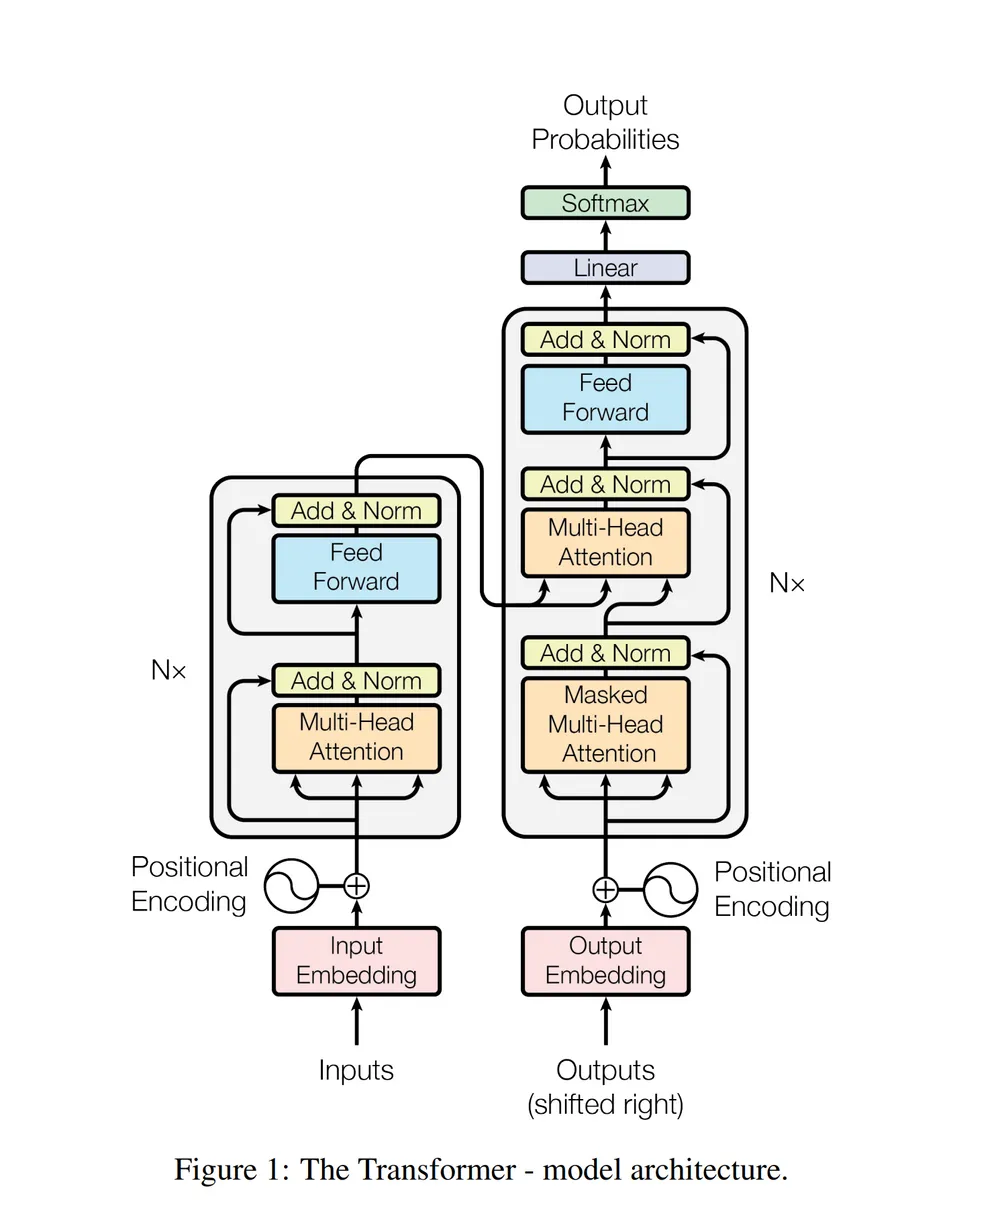

# 2. 어텐션 메커니즘(Attention Mechanism)



그래서 트랜스포머 구조를 이해하기 위해 **어텐션 메커니즘**을 이해할 필요가 있음

CNN을 알기위해 Convolution을 알아야 하는것 처럼



### 2.1. 기본 아이디어

디코더에서 출력 예측하는 시점마다 인코더의 전체 입력을 다시 참고함

여기서 전체 입력 중 예측하는 부분과 연관된 부분에 더 집중(Attenrion)해서 보기 때문에 

    어텐션 메커니즘(Attention Mechanism)

## 2.2 구성요소

    아래의 설명은 Self Attention을 기준으로 함
    쿼리(Query), 키(Key), 벨류(Value)

위의 3가지 구성요소는 입력데이터($x$)에 대한 "선형변환" **(벡터와 행렬의 곱) $ = [vector][matrix]$** 으로 생성됨
$$Q(Query) = xW_Q$$
$$K(Key) = xW_K$$
$$V(Value) = xW_V$$

$W_Q,W_K,W_V$는 가중치 행렬이며 모델이 학습하며 업데이트하는 값

$W_Q,W_K,W_V$는 임베딩 차원($d_{model}$)과 헤드의 개수($num\;head$)에 기반해 생성

임베딩 차원과 헤드가 뭔지는 트랜스포머 모델을 설명할 때


### 2.2.1 임베딩
입력 데이터에 대한 고차원의 연속적인 특징 공간이다. 말이 어려워 보이지만 임베딩하는 여러 방식들을 사용해 특징을 여러개 뽑아내는것이다.

"The cat sat on the mat"를 입력 데이터라 할 때 $d_{model} = 512$ 라고 하자

입력데이터에 대한 임베딩 결과는 $$x.shape = [6,512] = [입력데이터의\;길이,d_{model}]$$


In [20]:
import torch
data = "The cat sat on the mat"
d_model = 512

def embedding(data,d_model):
    #단어가 입력된 상황을 가정하고 토큰화 진행
    tokens = data.split()
    #토큰의 개수, d_model의 임베딩 생성됨
    return torch.rand(len(tokens), d_model)

embedding_matrix  = embedding(data,d_model)
print("임베딩 결과의 크기",embedding_matrix.shape)
print("임베딩 결과",embedding_matrix)

임베딩 결과의 크기 torch.Size([6, 512])
임베딩 결과 tensor([[0.9851, 0.7044, 0.6417,  ..., 0.3498, 0.6813, 0.5172],
        [0.7140, 0.8189, 0.6091,  ..., 0.1643, 0.1062, 0.4383],
        [0.8386, 0.8516, 0.8611,  ..., 0.6039, 0.0629, 0.0511],
        [0.0476, 0.0713, 0.8978,  ..., 0.0592, 0.2063, 0.8426],
        [0.8651, 0.2321, 0.9658,  ..., 0.6976, 0.5677, 0.4458],
        [0.4409, 0.8931, 0.8318,  ..., 0.0290, 0.9022, 0.8148]])


### 2.2.2 멀티-헤드

트렌스포머 모델은 입력 데이터를 여러 헤드에서 동시에 처리함

각 헤드마다 다른 관점에서 분석한다.

쿼리,키,벨류의 가중치 행렬 생성시 $$shape = [d_{model},{d_{model} \over num\;head}]$$으로 생성한다.

입력 데이터에 대한 임베딩에는 사용하지 않는다.

## 2.3 쿼리(Query)

현재 단어를 나타내는 벡터를 의미함

쿼리의 가중치 행렬

$$W_Q = \begin{bmatrix}
q_{11} & \cdots & q_{1(num\;head)}\\
\vdots & \ddots & \vdots \\
q_{(d_{model})1} & \cdots & q_{(d_{model})(num\;head)}\\
\end{bmatrix}$$

쿼리 가중치 행렬의 크기
$$W_Q.shape = [d_{model},{d_{model} \over num\;head}]$$

Q의 크기
$$Q.shape = [입력데이터의\;길이,{d_{model} \over num\;head}]$$



#### - 예시
"The cat sat on the mat"에서 "cat"이라는 단어를 분석한다고 가정할 때,$d_{model} = 512,num\;head=8 $ 이라고 하자

 "cat"에 대응되는 **쿼리 벡터**를 찾고싶다.



입력 데이터의 임베딩($x$)를 $x = \begin{bmatrix}x_{1,1} & \cdots & x_{1,512}\\
\vdots & \ddots & \vdots \\
x_{6,1} & \cdots & x_{6,512}\end{bmatrix}$라 하자,

 임의의 $W_Q = \begin{bmatrix}
q_{1,1} & \cdots & q_{1,64}\\
\vdots & \ddots & \vdots \\
q_{512,1} & \cdots & q_{512,64}\\
\end{bmatrix}$가 있을 때,
 
  선형변환($=xW_Q$) 된 결과
  
$$Q =
\begin{bmatrix}x_{1,1} & \cdots & x_{1,512}\\
\vdots & \ddots & \vdots \\
x_{6,1} & \cdots & x_{6,512}\end{bmatrix}
\begin{bmatrix}
q_{1,1} & \cdots & q_{1,64}\\
\vdots & \ddots & \vdots \\
q_{512,1} & \cdots & q_{512,64}\\
\end{bmatrix} 
=\begin{bmatrix}
(x_{1,1})(q_{1,1}) +\cdots + (x_{1,512})(q_{512,1})& \cdots & (x_{1,1})(q_{1,64}) +\cdots +(x_{1,512}q_{512,64}) \\
\vdots & \ddots & \vdots \\
(x_{6,1})(q_{1,1}) +\cdots + (x_{1,512})(q_{512,1})& \cdots & (x_{6,1})(q_{1,64}) +\cdots + (x_{6,512})(q_{512,64})\\
\end{bmatrix}$$

$$Q.shape = [6,64] = [입력데이터길이,{d_{model} \over num\;head}]$$

$$\begin{bmatrix} (x_{2,1})(q_{1,2}) +\cdots + (x_{2,512})(q_{512,2}) & ,\;\cdots & ,(x_{2,1})(q_{1,64}) +\cdots + (x_{2,512})(q_{512,64})\end{bmatrix}\;이\;"cat"에\;대한\;쿼리 벡터\; 이다.$$

In [8]:
import torch
import torch.nn as nn
# 설정
data = "The cat sat on the mat"
d_model = 512
num_heads = 8
head_dim = d_model // num_heads
# 랜덤함수로 임의의 임베딩 벡터 및 가중치 행렬 생성
def embedding(data,d_model):
    #단어가 입력된 상황을 가정하고 토큰화 진행
    tokens = data.split()
    #토큰의 개수, d_model의 임베딩 생성됨
    return torch.rand(len(tokens), d_model)

embedding_matrix = embedding(data,d_model)  # 6개 단어에 대한 임베딩
W_q = torch.rand(d_model, head_dim)  # 쿼리 가중치 행렬

print("문장 임베딩시 벡터의 크기",embedding_matrix.shape)
print("쿼리 가중치 행렬의 크기",W_q.shape)
# "cat"에 해당하는 임베딩 벡터 (예제에서는 두 번째 단어로 가정)
cat_embedding = embedding_matrix[1, :]  # "cat"의 임베딩

# "cat"에 대한 쿼리 벡터 계산
cat_query = torch.matmul(cat_embedding, W_q)
print()
print("cat에 대한 쿼리 벡터의 크기:", cat_query.shape)
print("cat에 대한 쿼리 벡터:", cat_query)


문장 임베딩시 벡터의 크기 torch.Size([6, 512])
쿼리 가중치 행렬의 크기 torch.Size([512, 64])

cat에 대한 쿼리 벡터의 크기: torch.Size([64])
cat에 대한 쿼리 벡터: tensor([126.7530, 126.7477, 125.9892, 125.6708, 121.0673, 118.2242, 120.0349,
        126.1817, 121.5843, 127.4763, 125.1348, 117.7800, 125.4988, 127.0261,
        122.9178, 123.5058, 122.0167, 126.1502, 124.4548, 121.0811, 129.9183,
        124.8791, 125.2189, 125.8380, 128.4730, 127.3037, 124.0913, 125.2077,
        117.9322, 130.1100, 126.5133, 119.5291, 123.4935, 133.0323, 115.3479,
        129.5890, 126.6831, 119.4234, 123.9116, 126.4938, 126.4543, 128.1191,
        129.0816, 117.0037, 119.4417, 122.7524, 128.6954, 120.4455, 117.2934,
        122.0824, 129.8965, 126.2648, 124.1676, 127.9894, 125.1102, 120.4204,
        120.0303, 119.3966, 124.3703, 120.8507, 120.1961, 120.5619, 124.1685,
        126.2433])


## 2.4 키(Key) - 벨류(Value)

- 기본개념: 키(Key) - 벨류(Value) 구조는 흔히 아래와 같은 딕셔너리 형에서 사용됨

    키값으로 벨류를 가져올 수 있다.


In [4]:
dict = {"2017" : "Transformer", "2018" : "BERT"}
print(dict["2018"])

BERT


키(Key)가중치 행렬 

$$W_K = \begin{bmatrix}
k_{11} & \cdots & k_{1(num\;head)}\\
\vdots & \ddots & \vdots \\
k_{(d_{model})1} & \cdots & k_{(d_{model})(num\;head)}\\
\end{bmatrix}$$

가중치 행렬의 크기
$$W_K.shape = [d_{model},{d_{model} \over num\;head}]$$

K의 크기
$$K.shape = [입력데이터의\;길이,{d_{model} \over num\;head}]$$

벨류(Value)가중치 행렬 

$$W_V = \begin{bmatrix}
v_{11} & \cdots & v_{1(num\;head)}\\
\vdots & \ddots & \vdots \\
v_{(d_{model})1} & \cdots & v_{(d_{model})(num\;head)}\\
\end{bmatrix}$$

가중치 행렬의 크기
$$W_V.shape = [d_{model},{d_{model} \over num\;head}]$$

V의 크기
$$V.shape = [입력데이터의\;길이,{d_{model} \over num\;head}]$$

#### 쿼리,키,벨류의 가중치 행렬은 모두 같은 크기를 가진다. 

## 2.5 Attention
### 2.5.1 Attention Score 계산
어텐션 스코어는 쿼리와 키의 관계를 나타낸다.

입력 시퀀스(=현재 쿼리)의 대한 전체요소들과의 가중치를 계산하는 것이다.

이 계산 방법에 따라 **다양한 방법**으로 구현 될 수 있다. 그 중 내적(Dot-Product)을 이용한 계산을 알아보자면
$$ Attention(Q,K) = softmax({QK^T \over \sqrt{d_k}}) $$
로 정의되며 싱글 헤드 어텐션과 멀티 헤드 어텐션일때 계산이 달라진다.

 - **멀티-헤드 어텐션**
$$ Attention(Q,K) = softmax({QK^T \over \sqrt{d_k}}) = softmax({QK^T \over \sqrt{{d_{model} \over num\;head}}})$$

 - 싱글-헤드셀프 어텐션(별로 중요하지 않아보인다. )
 $$ Attention(Q,K)= softmax({QK^T \over \sqrt{d_k}}) = softmax({QK^T \over \sqrt{{d_{model} \over 1}}}) = softmax({QK^T \over \sqrt{d_{model}}}) $$



In [31]:
#어텐션 스코어 계산 예제
import torch
import torch.nn.functional as F
import torch.nn as nn
# 설정
data = "The cat sat on the mat"
d_model = 512
num_heads = 8
head_dim = d_model // num_heads
# 랜덤함수로 임의의 임베딩 벡터 및 가중치 행렬 생성
def embedding(data,d_model):
    #단어가 입력된 상황을 가정하고 토큰화 진행
    tokens = data.split()
    #토큰의 개수, d_model의 임베딩 생성됨
    return torch.rand(len(tokens), d_model)

embedding_matrix = embedding(data,d_model)  # 6개 단어에 대한 임베딩
W_q = torch.rand(d_model, head_dim)  # 쿼리 가중치 행렬

print("문장 임베딩시 벡터의 크기",embedding_matrix.shape)
print("쿼리 가중치 행렬의 크기",W_q.shape)
# "cat"에 해당하는 임베딩 벡터 (예제에서는 두 번째 단어로 가정)
cat_embedding = embedding_matrix[1, :]  # "cat"의 임베딩

# "cat"에 대한 쿼리 벡터 계산
cat_query = torch.matmul(cat_embedding, W_q)
###################위와 동일#########################
# 랜덤함수로 임의의 임베딩 벡터 및 가중치 행렬 생성
W_k = torch.rand(d_model, head_dim)  # 키 가중치 행렬
print("키 가중치 행렬의 크기",W_q.shape)
keys = torch.matmul(embedding_matrix, W_k)

# 어텐션 스코어 계산
attention_scores = torch.matmul(cat_query, keys.T) / torch.sqrt(torch.tensor(d_model // num_heads, dtype=torch.float32))
attention_scores = F.softmax(attention_scores, dim=-1)
print()
print("cat에 대한 어텐션 스코어 크기:", attention_scores.shape)
print("cat에 대한 어텐션 스코어:", attention_scores)

문장 임베딩시 벡터의 크기 torch.Size([6, 512])
쿼리 가중치 행렬의 크기 torch.Size([512, 64])
키 가중치 행렬의 크기 torch.Size([512, 64])

cat에 대한 어텐션 스코어 크기: torch.Size([6])
cat에 대한 어텐션 스코어: tensor([0., 0., 1., 0., 0., 0.])


### 2.5.1 Attention Value 계산

어텐션 스코어를 바탕으로 각 벨류에서의 가중치를 부여해 쿼리벡터 하나에서 다른 요소에 대한 **의미**나 **특성** 그리고 **맥락**을 포함한다.

어텐션 스코어에 가중치가 부여된 벨류를 합산한다.

$$ Weighted\;Value = Attention\;Score\times V  = softmax({QK^T \over \sqrt{d_k}})V$$

#### 예시
앞서 구한 "cat"에 대한 어텐션 스코어를 바탕으로 "cat"에 대한 어텐션 벨류는? (d_model = 512, num head = 8)

벨류벡터는 앞선 쿼리,키와 같이 데이터 임베딩 벡터와 벨류 가중치 행렬의 곱으로 나타난다 
$$xW_V = \begin{bmatrix}x_{1,1} & \cdots & x_{1,512}\\
\vdots & \ddots & \vdots \\
x_{6,1} & \cdots & x_{6,512}\end{bmatrix}
\begin{bmatrix}
v_{1,1} & \cdots & v_{1,64}\\
\vdots & \ddots & \vdots \\
v_{512,1} & \cdots & v_{512,64}\\
\end{bmatrix} 
=\begin{bmatrix}
(x_{1,1})(v_{1,1}) +\cdots + (x_{1,512})(v_{512,1})& \cdots & (x_{1,1})(v_{1,64}) +\cdots +(x_{1,512}v_{512,64}) \\
\vdots & \ddots & \vdots \\
(x_{6,1})(q_{1,1}) +\cdots + (x_{1,512})(v_{512,1})& \cdots & (x_{6,1})(v_{1,64}) +\cdots + (x_{6,512})(v_{512,64})\\
\end{bmatrix} $$

$$V.shape = [6,64] = [입력데이터길이,{d_{model} \over num\;head}]$$

우리가 원하는건 "cat"에 대한 어텐션 벨류 이므로

$$(임의값 사용)\begin{bmatrix} 0&,0&,0&,0&,1&,0\end{bmatrix}
\begin{bmatrix}
(x_{1,1})(v_{1,1}) +\cdots + (x_{1,512})(v_{512,1})& \cdots & (x_{1,1})(v_{1,64}) +\cdots +(x_{1,512}v_{512,64}) \\
\vdots & \ddots & \vdots \\
(x_{6,1})(q_{1,1}) +\cdots + (x_{1,512})(v_{512,1})& \cdots & (x_{6,1})(v_{1,64}) +\cdots + (x_{6,512})(v_{512,64})\\
\end{bmatrix} \;이\;"cat"에\;대한\;어텐션\; 벨류\; 이다.$$

In [41]:
import torch
import torch.nn.functional as F

# 설정
data = "The cat sat on the mat"
d_model = 512
num_heads = 8
head_dim = d_model // num_heads
# 랜덤함수로 임의의 임베딩 벡터 및 가중치 행렬 생성
def embedding(data,d_model):
    #단어가 입력된 상황을 가정하고 토큰화 진행
    tokens = data.split()
    #토큰의 개수, d_model의 임베딩 생성됨
    return torch.rand(len(tokens), d_model)

embedding_matrix = embedding(data,d_model)  # 6개 단어에 대한 임베딩

W_q = torch.rand(d_model, head_dim)  # 쿼리 가중치 행렬
print("문장 임베딩시 벡터의 크기",embedding_matrix.shape)
print("쿼리 가중치 행렬의 크기",W_q.shape)
W_k = torch.rand(d_model, head_dim)  # 키 가중치 행렬
print("키 가중치 행렬의 크기",W_k.shape)
W_v = torch.rand(d_model, head_dim)  # 밸류 가중치 행렬
print("벨류 가중치 행렬의 크기",W_v.shape)
print()
# "cat"에 해당하는 임베딩 벡터 (예제에서는 두 번째 단어로 가정)
cat_embedding = embedding_matrix[1, :]  # "cat"의 임베딩
print("cat에 대한 임베딩 크기",cat_embedding.shape)


# 쿼리, 키, 밸류 벡터 계산
cat_query = torch.matmul(cat_embedding, W_q)
keys = torch.matmul(embedding_matrix, W_k)
values = torch.matmul(embedding_matrix, W_v)

# "cat"에 대한 어텐션 스코어 계산
attention_scores = torch.matmul(cat_query, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(head_dim, dtype=torch.float32))
attention_scores = F.softmax(attention_scores, dim=-1)

# "cat"에 대한 어텐션 벨류 계산
cat_attention_values = torch.matmul(attention_scores, values)

print("cat에 대한 어텐션 벨류 크기:", cat_attention_values.shape)
print("cat에 대한 어텐션 벨류:", cat_attention_values)


문장 임베딩시 벡터의 크기 torch.Size([6, 512])
쿼리 가중치 행렬의 크기 torch.Size([512, 64])
키 가중치 행렬의 크기 torch.Size([512, 64])
벨류 가중치 행렬의 크기 torch.Size([512, 64])

cat에 대한 임베딩 크기 torch.Size([512])
cat에 대한 어텐션 벨류 크기: torch.Size([64])
cat에 대한 어텐션 벨류: tensor([135.5012, 132.0180, 125.1697, 135.8944, 139.8328, 135.4594, 139.3117,
        132.7706, 135.6720, 142.4327, 137.8608, 131.1048, 137.3356, 126.7862,
        130.9028, 134.8892, 134.8144, 141.0328, 130.5714, 133.7393, 131.3661,
        134.1417, 140.4945, 137.5732, 133.9657, 139.9578, 139.7191, 132.9456,
        130.2146, 131.4727, 131.2268, 137.9176, 138.9715, 136.7318, 130.6440,
        138.4997, 136.6103, 140.2642, 133.3778, 138.4932, 148.1187, 132.9197,
        131.4083, 137.3910, 145.9701, 134.5276, 134.2988, 134.5674, 133.7662,
        125.7195, 136.8618, 138.8962, 130.4131, 145.2521, 128.5284, 132.3416,
        134.5885, 131.3524, 133.9937, 137.7670, 135.3696, 138.7210, 134.6089,
        143.5262])


# 3. 트랜스포머 모델
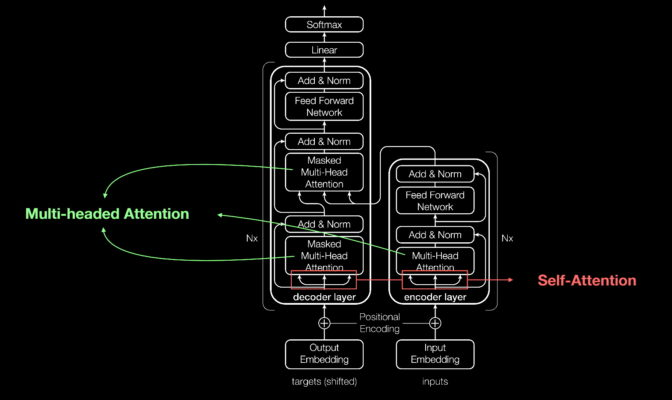

앞서 설명한 멀티 헤드 어텐션 개념으로 계산한다.

## 3.1. 셀프 어텐션

여지껏 설명한 어텐션 벨류를 계산하는 과정이다.
$$ Attention(Q,K,V) = softmax({QK^T \over \sqrt{d_k}})V = softmax({QK^T \over \sqrt{{d_{model} \over num\;head}}})V$$

입력된 데이터 안에서의 관계를 파악할 수 있다.

In [42]:
# 전체적인 과정 앞선 예제들은 cat 단어에 대한 예시였음
import torch
import torch.nn.functional as F

# 설정
d_model = 512
num_heads = 8
head_dim = d_model // num_heads

# 임의의 임베딩 및 가중치 행렬 생성
embedding_matrix =  embedding(data,d_model)  # 6개 단어에 대한 임베딩
W_q = torch.rand(d_model, head_dim)  # 쿼리 가중치 행렬
W_k = torch.rand(d_model, head_dim)  # 키 가중치 행렬
W_v = torch.rand(d_model, head_dim)  # 밸류 가중치 행렬

# 쿼리, 키, 밸류 벡터 계산
queries = torch.matmul(embedding_matrix, W_q)
keys = torch.matmul(embedding_matrix, W_k)
values = torch.matmul(embedding_matrix, W_v)

# 어텐션 스코어 계산
attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(head_dim, dtype=torch.float32))
attention_scores = F.softmax(attention_scores, dim=-1)

# 어텐션 벨류 계산
attention = torch.matmul(attention_scores, values)

print("어텐션 벨류 크기:", attention.shape)
print("어텐션 벨류:", attention)

어텐션 벨류 크기: torch.Size([6, 64])
어텐션 벨류: tensor([[127.9598, 135.8573, 129.8106, 135.0408, 131.4271, 131.0238, 135.3094,
         136.2675, 135.5756, 133.6575, 130.5642, 134.4999, 131.1972, 140.2212,
         139.0600, 133.1449, 140.0540, 133.7509, 136.4191, 131.1398, 133.5385,
         140.9329, 133.3601, 128.8225, 134.1572, 136.4457, 135.5625, 132.9610,
         131.9798, 134.9438, 133.3240, 129.6180, 127.7841, 134.5896, 133.7307,
         134.1195, 133.1934, 132.3858, 133.6541, 138.5786, 130.9156, 136.9396,
         135.8650, 134.0912, 134.9815, 127.1588, 131.3499, 134.4217, 135.7315,
         139.1427, 143.7802, 131.9157, 133.8102, 132.4975, 134.7213, 132.3748,
         133.1901, 131.9047, 135.8324, 130.9090, 133.4690, 130.7578, 136.7964,
         131.1093],
        [127.9598, 135.8573, 129.8106, 135.0408, 131.4271, 131.0238, 135.3094,
         136.2675, 135.5756, 133.6575, 130.5642, 134.4999, 131.1972, 140.2212,
         139.0600, 133.1449, 140.0540, 133.7509, 136.4191, 131.1398, 133

## 3.2. 피드포워드 신경망

일반적으로는 은닉층을 말한다.

트랜스 포머에서는 셀프 어텐션 다음에 위치하기 때문에 추가적인 비선형 변환(ReLU)가 적용되는 층이다. 쉽게 생각하면 Activation을 하기위한 정보전달 레이어이다.

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Feedforward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)  # ReLU 활성화 함수 적용
        x = self.fc2(x)
        return x

## 3.3. Positional Encoding

모델에 입력된 데이터가 임베딩 되었을 때 어떤 요소가 앞인지 뒤인지 알기 어렵다. 따라서 셀프 어텐션을 하기 전 순서정보를 제공하는 레이어이다.

$$ PE_{(pos,2i) = sin(pos/10000^{2i/d_{model}})}$$
$$ PE_{(pos,2i+1) = cos(pos/10000^{2i/d_{model}})}$$

두 행렬의 사이즈는 임베딩 된 데이터의 사이즈와 같다
$$ PE.shape = [입력데이터\;길이,d_{model}]$$

포지셔널 인코딩을 하면 임베딩 된 데이터에 위의 계산된 값이 합쳐지게 된다.
짝수 인덱스는 $ PE_{(pos,2i) = sin(pos/10000^{2i/d_{model}})}$ 가 합쳐지게되고 홀수 인덱스는 $PE_{(pos,2i+1) = cos(pos/10000^{2i/d_{model}})}$ 가 합쳐지게 된다.

pos는 행의 값이며 i는 열의 값이다.
$$ f(pos,i) = \begin{cases}
    x + sin(pos/10000^{2i/d_{model}}), & \text{i 가 짝수일 때} \newline
    x + cos(pos/10000^{2i/d_{model}}), & \text{i 가 홀수일 때}
\end{cases}

 = \begin{bmatrix}x_{1,1} + PE_{(1,1)}& \cdots & x_{1,d_{model}}+PE_{(1,d_{model})}\\
 x_{2,1} + PE_{(2,1)}& \cdots & x_{2,d_{model}}+ PE_{(2,d_{model})}\\
\vdots & \ddots & \vdots \\
x_{입력데이터\;길이,1}+ PE_{(입력데이터\;길이,1)} & \cdots & x_{입력데이터\;길이,d_{model}}+ PE_{(입력데이터\;길이,d_{model})}\end{bmatrix}


$$

## 3.4. 인코더(Encoder)

일반적으로 분류의 역할
ViT(Vision Transformer)에서는 이미지의 전체적인 맥락을 이해하고 패턴을 학습하는 역할을 수행

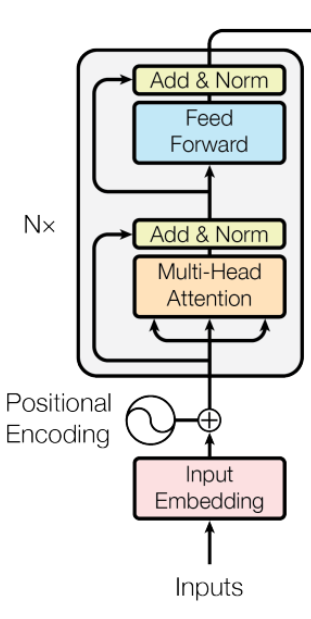

### 3.4.1 정보입력

임베딩 된 학습데이터가 입력으로 들어오게 된다.

### 3.4.2 포지셔널 인코딩 적용

임베딩 된 학습데이터에 단어의 위치정보가 합산 된다.


### 3.4.3 Self-Attention

한 레이어에서 1번 일어남

### 3.4.4 Add&Norm

잔차연결과 정규화를 수행한다.(더 빠른 수렴을 위함)

잔차연결은 입력을 레이어의 출력에 더하므로서 기울기 소실문제를 완화 하고자 한다. $output = Result(x)+x$

정규화는 딥러닝에서 사용한는 개념과 동일하다.

### 3.4.5 FeedForward

위의 설명 그대로 적용된다.

## 3.5. 디코더(Decoder)

일반적으로 생성

Vit에서는 일반적으로 사용되지 않음, 이미지 캡셔닝, 이미지 생성, 스타일 변환등의 작업 수행가능

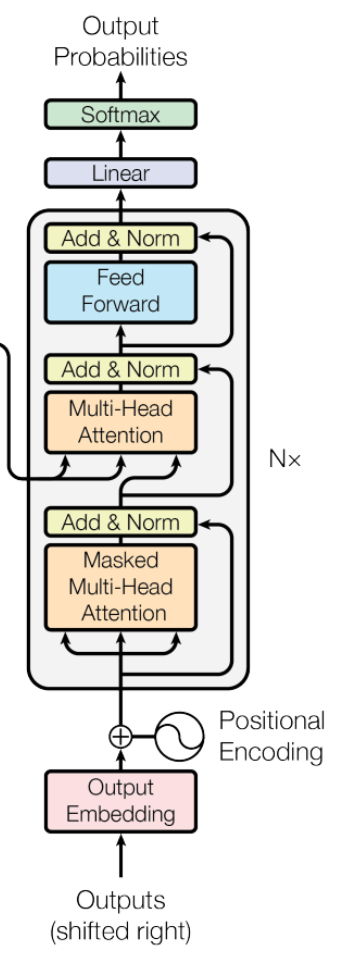


### 3.6.1 마스크드 셀프 어텐션(Masked Self-Attention)

디코더에선 어텐션 계산시 현재 단어 및 이전 단어로 어텐션 벨류를 구한다.

$$ Attention(Q,K,V) = softmax({QK^T \over \sqrt{d_k}})V = softmax({QK^T \over \sqrt{{d_{model} \over num\;head}}})V$$

로 계산 자체는 같지만 임베딩 된 데이터에서 현재 참조하는 데이터보다 미래의 데이터에 참조하지 못하도록 마스크(mask)를 적용시켜 어텐션 벨류를 구한다.

마스크는 포지셔널 인코딩에서 음의 무한대값을 적용시키는 것

1회 반복(iteration)시 쿼리의 모든 행에 대한 어텐션 벨류를 동시에 계산함

행의 개수만큼의 계산을 반복되지만 한번에 계산하기 때문에 1 iteration에서 1번 계산되는것

#### 3.6.2 인코더-디코더 어텐션 (Encoder-Decoder Attention)

앞선 마스크드 셀프 어텐션의 출력을 쿼리Q로 사용한다.
키K와 벨류V는 인코더에서 나온 출력을 사용한다.
$$Attention(Q_{masked\;attention\;output},K_{encoder\;output},V_{encoder\;output})$$

한 레이어에서 1번 일어남


## 3.6. 멀티 헤드 어텐션

병렬학습을 위한 방식이다. 여태 쿼리, 키. 벨류의 행렬의 크기를 $[d_{model},\frac{num\;head}{d_{model}}]$로 정의한 것도 $num\;head$만큼 병렬로 작업하기 때문이다.

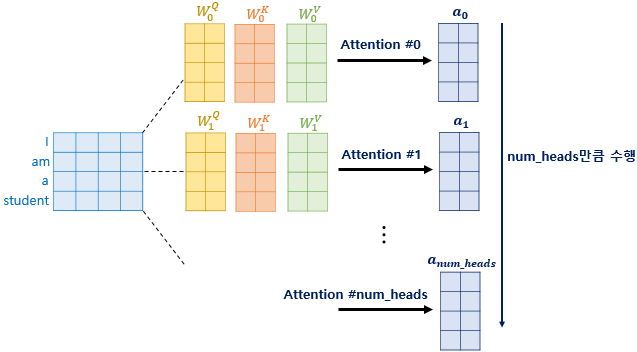

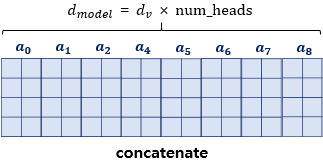

## 트랜스포머 구조

인코더와 디코더를 포함하는 전형적인 트랜스포머 구조입니다. 이 모델은 기계 번역과 같은 시퀀스-투-시퀀스 작업에 사용됩니다.

In [1]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_encoder_layers, num_decoder_layers):
        super(Transformer, self).__init__()
        
        # 인코더 정의: 입력 시퀀스를 처리하고 문맥 정보를 생성
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads),
            num_layers=num_encoder_layers
        )

        # 디코더 정의: 인코더의 출력과 목표 시퀀스를 사용하여 출력 시퀀스를 생성
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads),
            num_layers=num_decoder_layers
        )

        # 입력 임베딩: 입력 시퀀스의 각 토큰을 d_model 차원의 벡터로 변환
        self.input_embedding = nn.Embedding(input_dim, d_model)

        # 출력 선형 레이어: 디코더의 출력을 최종 출력 차원으로 변환
        self.output_linear = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        # 소스 시퀀스 임베딩
        src = self.input_embedding(src)

        # 타겟 시퀀스 임베딩
        tgt = self.input_embedding(tgt)

        # 인코더를 통한 소스 시퀀스 처리
        memory = self.encoder(src)

        # 디코더를 통한 타겟 시퀀스 처리
        output = self.decoder(tgt, memory)

        # 최종 출력 생성
        return self.output_linear(output)


코드 설명:

이 코드는 트랜스포머 모델의 기본 구조를 나타냅니다.

input_dim은 입력 시퀀스의 어휘 크기, d_model은 임베딩 차원, n_heads는 어텐션 헤드의 수, num_encoder_layers와 num_decoder_layers는 각각 인코더와 디코더의 층 수를 나타냅니다.

모델은 입력 시퀀스를 받아 인코더를 통해 처리하고, 이를 바탕으로 디코더가 목표 시퀀스를 생성합니다.

최종적으로, 디코더의 출력은 선형 레이어를 통해 최종 출력 차원으로 변환됩니다.

## 비전 트랜스포머(ViT) 구조

이미지를 패치로 분할하고, 이를 트랜스포머 인코더를 통해 처리하는 구조입니다. 주로 이미지 분류 작업에 사용됩니다.

In [ ]:
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, d_model, num_heads, num_layers):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        num_patches = (image_size // patch_size) ** 2

        # 패치 임베딩: 이미지를 패치로 분할하고 각 패치를 벡터로 변환
        self.patch_embedding = nn.Linear(patch_size * patch_size * 3, d_model)

        # 위치 인코딩: 패치의 위치 정보를 나타내는 인코딩
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))

        # 클래스 토큰: 이미지 분류를 위한 특별한 토큰
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # 트랜스포머 인코더: 패치 간의 관계를 학습
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )

        # MLP 헤드: 최종 분류를 위한 다층 퍼셉트론
        self.mlp_head = nn.Sequential(
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # 이미지를 패치로 분할
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.patch_size * self.patch_size * 3)

        # 패치 임베딩 및 위치 인코딩 적용
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_embedding

        # 트랜스포머 인코더를 통한 처리
        x = self.transformer(x)

        # 분류를 위한 MLP 헤드
        x = self.mlp_head(x[:, 0])
        return x


### 코드 설명

- 이 코드는 Vision Transformer (ViT) 모델의 기본 구조를 나타냅니다.
- image_size는 입력 이미지의 크기, patch_size는 패치의 크기, num_classes는 분류할 클래스의 수, d_model은 임베딩 차원, num_heads는 어텐션 헤드의 수, num_layers는 트랜스포머 인코더의 층 수를 나타냅니다.
- 모델은 이미지를 패치로 분할하고, 각 패치를 임베딩한 후 트랜스포머 인코더를 통해 처리합니다.
- 위치 인코딩과 클래스 토큰은 이미지의 전체적인 컨텍스트를 이해하는 데 도움을 줍니다.
- 최종적으로, MLP 헤드를 통해 이미지 분류를 수행합니다.

## Vit Segmetation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViTSegmentation(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, d_model, num_heads, num_layers):
        super(ViTSegmentation, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        num_patches = (image_size // patch_size) ** 2

        # 패치 임베딩: 이미지를 패치로 분할하고 각 패치를 벡터로 변환
        self.patch_embedding = nn.Linear(patch_size * patch_size * 3, d_model)

        # 위치 인코딩: 패치의 위치 정보를 나타내는 인코딩
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches, d_model))

        # 트랜스포머 인코더: 패치 간의 관계를 학습
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )

        # 세그멘테이션 헤드: 각 패치에 대한 세그멘테이션 레이블을 예측
        self.segmentation_head = nn.Sequential(
            nn.Linear(d_model, num_classes),
            nn.Upsample(scale_factor=patch_size, mode='nearest')
        )

    def forward(self, x):
        # 이미지를 패치로 분할
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.patch_size * self.patch_size * 3)

        # 패치 임베딩 및 위치 인코딩 적용
        x = self.patch_embedding(x)
        x += self.positional_embedding

        # 트랜스포머 인코더를 통한 처리
        x = self.transformer(x)

        # 세그멘테이션 헤드를 통한 각 패치의 레이블 예측
        x = self.segmentation_head(x)

        # 원본 이미지 크기로 업샘플링
        x = x.permute(0, 2, 1).view(x.size(0), *num_classes, *image_size, *image_size)
        return x


### 코드 설명
- 이 모델은 ViT 구조를 기반으로 하며, 이미지 세그멘테이션을 위한 특별한 헤드를 포함합니다.
- image_size, patch_size, num_classes, d_model, num_heads, num_layers는 각각 이미지 크기, 패치 크기, 클래스 수, 임베딩 차원, 어텐션 헤드 수, 인코더 층 수를 나타냅니다.
- patch_embedding은 이미지를 패치로 분할하고 각 패치를 임베딩합니다.
- positional_embedding은 패치의 위치 정보를 제공합니다.
- transformer는 패치 간의 관계를 학습합니다.
- segmentation_head는 각 패치에 대한 세그멘테이션 레이블을 예측합니다. 이 헤드는 선형 레이어와 업샘플링을 포함합니다.
- 최종 출력은 원본 이미지 크기로 업샘플링되어 각 픽셀에 대한 클래스 레이블을 제공합니다.